In [437]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import branca
import matplotlib.pyplot as plt
import geojsoncontour
import geopandas as gpd
import json
import xarray as xr
import folium
import panel as pn
import pydeck as pdk
import datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.figure import Figure

In [438]:
import matplotlib as mpl

In [ ]:
def palau_eez(df):
    in_palau = []
    longlat = df[['longitude','latitude']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['longitude', 'latitude']].apply(tuple, axis=1).isin(in_palau)]

In [4]:
def filter_palau(df):
    filtered = df[(df["latitude"]>= 1.25)&
                                (df["latitude"]<=13.00)&(df["longitude"]<=139.00)&
                                (df["longitude"]>=128)]
    return filtered

In [5]:
wavefp, wavedp, wavehs = wave.fp.to_dataframe(), wave.dp.to_dataframe(), wave.hs.to_dataframe()
wavefp, wavedp, wavehs = wavefp.dropna(), wavedp.dropna(), wavehs.dropna()
wavefp = wavefp.reset_index()
wavedp = wavedp.reset_index()
wavehs = wavehs.reset_index()
#optional line, next line filters more specifically - depends on need
wavefp, wavedp, wavehs = filter_palau(wavefp), filter_palau(wavedp), filter_palau(wavehs)
wavefp, wavedp, wavehs = palau_eez(wavefp), palau_eez(wavedp), palau_eez(wavehs)

In [6]:
def getIconJSON(datetime,wavedp):
    #np.datetime64('2023-01-01')
    #wavehs[wavehs['time'] == pd.to_datetime(date_slider.value)]
    direction_slice = wavedp[wavedp['time']==pd.to_datetime(datetime)]
    
    iconurl = "https://upload.wikimedia.org/wikipedia/commons/6/61/Black_Up_Arrow.png"

    icon_data = {
        # Icon from Wikimedia, used the Creative Commons Attribution-Share Alike 3.0
        # Unported, 2.5 Generic, 2.0 Generic and 1.0 Generic licenses
        "url": iconurl,
        "width": 364,
        "height": 434,
        #"y" = 
        "anchorY": 50,
    }
    
    icon_list = []
    for index, row in direction_slice.iterrows():
        icon_list.append({"latitude":row["latitude"],"longitude":row["longitude"],"dp":row["dp"],"icon_data":icon_data})
        
    return json.loads(json.dumps(icon_list))

In [7]:
def getGeoJSON(time,wavehs):

    wavehs_slice = wavehs[wavehs['time'] == pd.to_datetime(time)]

    coordinates = wavehs_slice[['latitude','longitude','hs']]
    coordinates = coordinates.drop_duplicates()

    x_orig = np.asarray(coordinates.longitude.tolist())
    y_orig = np.asarray(coordinates.latitude.tolist())
    z_orig = np.asarray(coordinates.hs.tolist())

    colors = ['#0000ff','#0099cc','#009999','#ccff66','#ffff66','#ffcc00','#ff6600','#cc0000']
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

    levels = len(colors)
    vmin   = min(coordinates.hs.tolist())
    vmax   = max(coordinates.hs.tolist())
    cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)



    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None',antialiased=True, vmin=vmin, vmax=vmax)

    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    df2 = gpd.read_file('palauEEZ.geojson')
    with open("contourplot_wave.geojson", "w") as text_file:
        text_file.write(geojson)
    df1 = gpd.read_file("contourplot_wave.geojson")
    df3 = gpd.read_file('palau.geojson')
    df3 =df3.drop(['type','id','tags','meta'],axis = 1)
    df3 = df3[df3.geometry.type != 'LineString']
    merged = gpd.overlay(df2,df1, how='intersection')
    merged = gpd.overlay(merged,df3, how='difference')
    merged_json = merged.to_json()

    R,G,B = [], [],[]
    for color in merged['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    merged['R'] = R
    merged['G'] = G
    merged['B'] = B
    mergedrgb_json = merged.to_json()
    loaded = json.loads(mergedrgb_json)
    return loaded

In [448]:
def getDeckGL(geo_json,icon_json):
    json_spec = {
    "initialViewState": {
        "latitude": 6.61,
        "longitude": 133.23,
        "maxZoom": 15,
        "minZoom": 5,
        "pitch": 0,
        "zoom": 7
    },
    "layers": [{
        "@@type": "GeoJsonLayer",
        "data": geo_json,
        "getElevation": 0,
        "getFillColor": "@@=[properties.R, properties.G, properties.B]",
        "getLineColor": "@@=[properties.R, properties.G, properties.B]",
        "extruded": True,
        "pickable": True
    },
    {
        "@@type": "IconLayer",
        "data": icon_json,
        "getAngle": "@@=180-dp",
        "getIcon": "@@=icon_data",
        "getPosition": "@@=[longitude, latitude]",
        "getSize": 10,
        "id": "9706b233-57f5-410a-8a94-2d39f94b326b",
        "pickable": True,
        "sizeScale": 1,
    },],
    "mapStyle": "https://basemaps.cartocdn.com/gl/positron-gl-style/style.json",
    "views": [
        {"@@type": "MapView", "controller": True}
    ]
}

    deck_gl = pn.pane.DeckGL(json_spec,
                             #mapbox_api_key=MAPBOX_KEY,
                             sizing_mode='stretch_width', 
                             height=600)
    return deck_gl

In [9]:
def colorbar_mpl(wavehs,full_directory):
#     wavehs_slice = wavehs[wavehs['time'] == pd.to_datetime(time)]
    coordinates = wavehs[['latitude','longitude','hs']]
    coordinates = coordinates.drop_duplicates()

    colors = ['#0000ff','#0099cc','#009999','#ccff66','#ffff66','#ffcc00','#ff6600','#cc0000']
    
    levels = len(colors)
    vmin   = min(coordinates.hs.tolist())
    vmax   = max(coordinates.hs.tolist())
    cmap = mpl.colors.ListedColormap(colors)
    tiers = np.linspace(vmin,vmax,levels+1).tolist()
    spacing = [round(x,2) for x in tiers]

    bounds = spacing
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))

    cfig, ax = plt.subplots(figsize=(8,1))
    cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Significant Wave Height")
    cfig.savefig(full_directory)
    return cfig

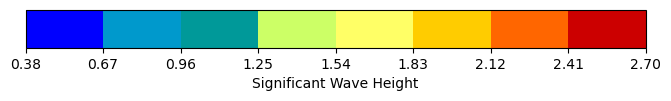

In [469]:
import os
waveArrow = os.getcwd() + '/jsonFiles/waveArrow/'
waveContour = os.getcwd() + '/jsonFiles/waveContour/'

In [471]:
start=dt.datetime(2023,1,1)
end=dt.datetime(2023,1,31)
delta = timedelta(days=1)

dList = []
while start <= end:
    dList.append(start.strftime("%Y-%m-%d"))
    start += delta

/opt/anaconda3/envs/pydeck/lib/python3.9/site-packages/geojsoncontour/utilities/multipoly.py:33: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)


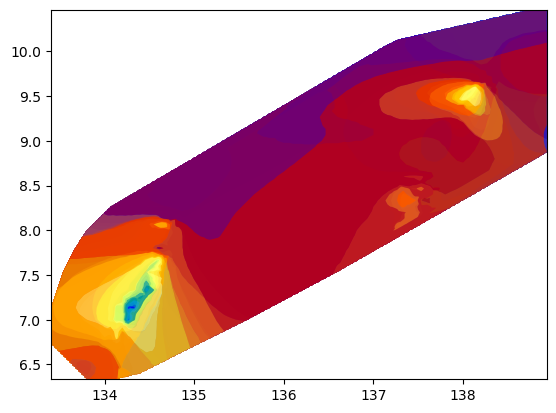

In [474]:
from datetime import date, timedelta

start=dt.datetime(2023,1,1)
end=dt.datetime(2023,1,31)
delta = timedelta(days=1)

colorbar_mpl(wavehs,'./waveColorbar' + start.strftime("%Y-%m-%d") + "_" +  end.strftime("%Y-%m-%d") ".png")

#TODO: Change in future to include option to only produce images instead of json files
#TODO: Create Voronoi "gridded" version instead of contour
while start <= end:

    with open(waveArrow + 'waveArrow' + start.strftime("%Y-%m-%d") +'.json', 'w') as f:
        json.dump(getIconJSON(start,wavedp), f)
        
    with open(waveContour + 'waveContour' + start.strftime("%Y-%m-%d")+'.json', 'w') as f:
        json.dump(getGeoJSON(start,wavehs), f)
        
    start += delta


In [454]:
#Create NGAARARD Buoy Icon

iconurl = "https://upload.wikimedia.org/wikipedia/commons/4/44/Plain_Yellow_Star.png"

icon_data = {
    # Icon from Wikimedia, used the Creative Commons Attribution-Share Alike 3.0
    # Unported, 2.5 Generic, 2.0 Generic and 1.0 Generic licenses
    "url": iconurl,
    "width": 364,
    "height": 434,
    #"y" = 
    "anchorY": 50,
}

=
icon_list = []
icon_list.append({"latitude": 7.62963 ,"longitude":134.67043,"icon_data":icon_data,"name": "NGARAARD, BABELDAOB, PALAU - 219"})

json_object = json.dumps(icon_list, indent=4)
 
with open("stationicon.json", "w") as outfile:
    outfile.write(json_object)